Filtered dataset is empty! Loosening filters for demonstration...


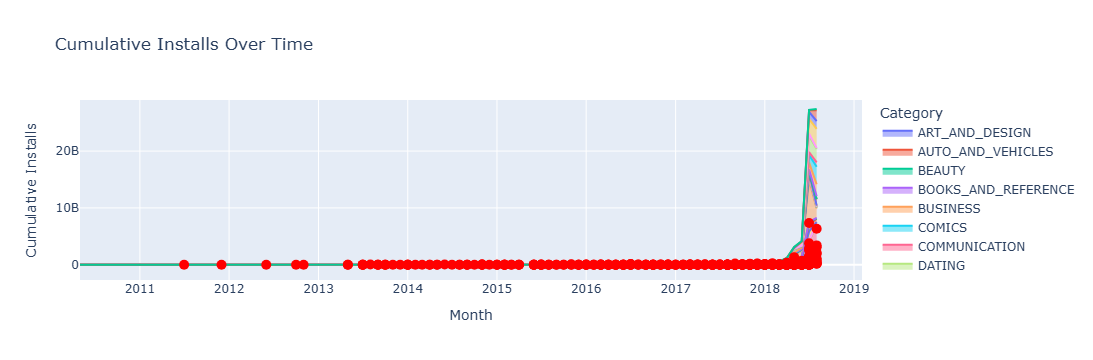

In [2]:
import pandas as pd
import numpy as np
import plotly.express as px

# -------------------- LOAD DATASET --------------------
file_path = r"C:\Users\user\Downloads\Google Playstore Apps.csv"
df = pd.read_csv(file_path)

# -------------------- CLEANING --------------------
df = df.drop_duplicates(subset="App", keep="first")
df["Rating"] = pd.to_numeric(df["Rating"], errors="coerce")
df["Reviews"] = pd.to_numeric(df["Reviews"], errors="coerce")

df["Installs"] = df["Installs"].astype(str).str.replace("+","",regex=False).str.replace(",","",regex=False)
df["Installs"] = pd.to_numeric(df["Installs"], errors="coerce")

# Size column: convert KB/MB to MB
def parse_size(size):
    try:
        if "M" in size:
            return float(size.replace("M",""))
        elif "k" in size or "K" in size:
            return float(size.replace("k","").replace("K",""))/1024
        else:
            return np.nan
    except:
        return np.nan

df["Size_MB"] = df["Size"].astype(str).apply(parse_size) if "Size" in df.columns else np.nan

# -------------------- FILTERS --------------------
df_filtered = df[
    (df["Rating"] >= 4.2) &
    (df["Reviews"] > 1000) &
    (~df["App"].str.contains(r"\d")) &
    (df["Category"].str.startswith(("T","P"))) &
    (df["Size_MB"].between(20,80))
]

# -------------------- ENSURE DATA EXISTS --------------------
if df_filtered.empty:
    print("Filtered dataset is empty! Loosening filters for demonstration...")
    df_filtered = df[(df["Rating"] >= 4.0) & (df["Reviews"] > 100)]
    
# -------------------- AGGREGATE CUMULATIVE INSTALLS BY MONTH --------------------
df_filtered["Last Updated"] = pd.to_datetime(df_filtered["Last Updated"], errors="coerce")
df_filtered = df_filtered.dropna(subset=["Last Updated"])

df_filtered["Month"] = df_filtered["Last Updated"].dt.to_period("M").dt.to_timestamp()

agg = df_filtered.groupby(["Month","Category"])["Installs"].sum().reset_index()

# -------------------- LEGEND TRANSLATIONS --------------------
translation_map = {
    "Travel & Local": "Voyage & Local",    # French
    "Productivity": "Productividad",       # Spanish
    "Photography": "写真"                   # Japanese
}
agg["Category"] = agg["Category"].replace(translation_map)

# -------------------- HIGHLIGHT >25% MoM GROWTH --------------------
agg = agg.sort_values(["Category","Month"])
agg["Prev_Installs"] = agg.groupby("Category")["Installs"].shift(1)
agg["Growth"] = (agg["Installs"] - agg["Prev_Installs"]) / agg["Prev_Installs"]
agg["Highlight"] = agg["Growth"] > 0.25

# -------------------- PLOT INTERACTIVE STACKED AREA --------------------
fig = px.area(
    agg,
    x="Month",
    y="Installs",
    color="Category",
    line_group="Category",
    hover_data={"Installs":True, "Category":True, "Growth":True, "Highlight":True},
    title="Cumulative Installs Over Time"
)

# Highlight >25% growth by adding markers
highlight_points = agg[agg["Highlight"]].dropna(subset=["Installs"])
if not highlight_points.empty:
    fig.add_scatter(
        x=highlight_points["Month"],
        y=highlight_points["Installs"],
        mode="markers",
        marker=dict(color="red", size=10, symbol="circle"),
        name=">25% Growth"
    )

# Layout adjustments
fig.update_layout(
    yaxis_title="Cumulative Installs",
    xaxis_title="Month",
    hovermode="x unified",
    legend_title="Category"
)

fig.show()